In [1]:
%load_ext autoreload
%autoreload 2
from qiskit.ignis.verification import state_tomography_circuits, StateTomographyFitter
from qiskit.tools import job_monitor

from MPS_decomposition.hdf5_reader import Hdf5Reader
from MPS_decomposition.basic_decomposer import BasicDecomposer

from qiskit import QuantumCircuit, transpile, Aer, IBMQ
IBMQ.save_account(
    '280beccbee94456a161a6cbc217e1366bc278bf60e22bd30281fa0ca5bec6e50897278ef818f3c53f6700e04b9ed32ea364195044413b7e02836a79d886b03d9',
    overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-research')

C:\Users\david\AppData\Local\Temp\ipykernel_22164\2128973426.py:3: DeprecationWarning: The qiskit.ignis package is deprecated and has been supersceded by the qiskit-experiments project. Refer to the migration guide: https://github.com/Qiskit/qiskit-ignis#migration-guide on how to migrate to the new project.
  from qiskit.ignis.verification import state_tomography_circuits, StateTomographyFitter


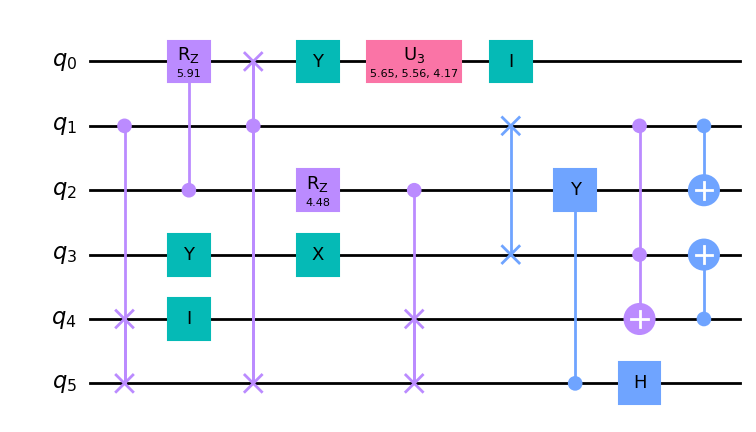

In [2]:
#Create Random State
n_qubits = 6
from qiskit.circuit.random import random_circuit
import qiskit.quantum_info as qi

circ = random_circuit(n_qubits, 5, measure=False)
state_vector = qi.Statevector.from_instruction(circ)
tomo_circuits = state_tomography_circuits(circ, circ.qubits)
circ.draw(output='mpl')


## $$\huge \text{Circuit Devision}$$

In [3]:
#Breaking down the circuit to 3 parts (IBM accepts maximum of 300 circuits per job)
import qiskit

part1_1 = []
part2_1 = []
part3_1 = []
for i in range(len(tomo_circuits)):
    if i <= 250:
        part1_1.append(tomo_circuits[i])
    elif i <= 500:
        part2_1.append(tomo_circuits[i])
    elif i <= 750:
        part3_1.append(tomo_circuits[i])

In [4]:
#Change backend
backend = Aer.get_backend('qasm_simulator')
job1_1 = qiskit.execute(part1_1, backend, shots=8000,optimization_level=0).result().get_counts()


In [5]:
job2_1 = qiskit.execute(part2_1, backend, shots=8000,optimization_level=0).result().get_counts()


In [6]:
job3_1 = qiskit.execute(part3_1, backend, shots=8000,optimization_level=0).result().get_counts()


In [7]:
full_counts = job1_1 +job2_1+job3_1

## $$\huge \text{Tomography}$$

In [8]:
#Full tomography:
import numpy as np
import tomography
matrix_sim_com = tomography.get_density_matrix(full_counts,dims=n_qubits,shots=8000);
fid_sim_com = tomography.calc_fidelity(matrix_sim_com,state_vector)
print(fid_sim_com)

(0.9987190835583986+0j)


In [9]:
import copy
results_copy = copy.deepcopy(full_counts)
EmptyCircuit = results_copy[0]
for key in EmptyCircuit.keys():
    EmptyCircuit[key] = 0

In [10]:
x = [i for i in range(1,728,5)]
print(x)

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46, 51, 56, 61, 66, 71, 76, 81, 86, 91, 96, 101, 106, 111, 116, 121, 126, 131, 136, 141, 146, 151, 156, 161, 166, 171, 176, 181, 186, 191, 196, 201, 206, 211, 216, 221, 226, 231, 236, 241, 246, 251, 256, 261, 266, 271, 276, 281, 286, 291, 296, 301, 306, 311, 316, 321, 326, 331, 336, 341, 346, 351, 356, 361, 366, 371, 376, 381, 386, 391, 396, 401, 406, 411, 416, 421, 426, 431, 436, 441, 446, 451, 456, 461, 466, 471, 476, 481, 486, 491, 496, 501, 506, 511, 516, 521, 526, 531, 536, 541, 546, 551, 556, 561, 566, 571, 576, 581, 586, 591, 596, 601, 606, 611, 616, 621, 626, 631, 636, 641, 646, 651, 656, 661, 666, 671, 676, 681, 686, 691, 696, 701, 706, 711, 716, 721, 726]


In [11]:
import random
#Half tomography:
import tomography
x = [i for i in range(1,728,5)]
fidelities_raw = []
fidelities_factor = []
fidelities_factor_I = []
fidelities_error = []
fidelities_factor_error = []
fidelities_factor_I_error = []

for n in x:
    print(n)
    raw = []
    factor = []
    factor_i = []
    for j in range(50):
        k = 728-n
        results_copy = copy.deepcopy(full_counts)
        remove = random.sample(range(len(full_counts)-1),k)
        for i in remove:
            results_copy[i] = EmptyCircuit
        matrix_sim_com = tomography.get_density_matrix(results_copy,dims=n_qubits,shots=8000);
        fixed_mat = matrix_sim_com*(3**n_qubits/(3**n_qubits-k))
        fixed_factor = matrix_sim_com*(3**n_qubits/(3**n_qubits-k)) - np.identity(2**n_qubits)*(3**n_qubits/(3**n_qubits-k))*(1/2**n_qubits)

        raw.append(tomography.calc_fidelity(matrix_sim_com,state_vector))
        factor.append(tomography.calc_fidelity(fixed_mat,state_vector))
        factor_i.append(tomography.calc_fidelity(fixed_factor,state_vector))

    fidelities_raw.append(sum(raw)/len(raw))
    fidelities_error.append((np.std(raw)))

    fidelities_factor.append(sum(factor)/len(factor))
    fidelities_factor_error.append((np.std(factor)))

    fidelities_factor_I.append(sum(factor_i)/len(factor_i))
    fidelities_factor_I_error.append((np.std(factor_i)))
    #fid_sim_com = tomography.calc_purity(fixed_mat)


1
6
11
16
21
26
31
36
41
46
51
56
61
66
71
76
81
86
91
96
101
106
111
116
121
126
131
136
141
146
151
156
161
166
171
176
181
186
191
196
201
206
211
216
221
226
231
236
241
246
251
256
261
266
271
276
281
286
291
296
301
306
311
316
321
326
331
336
341
346
351
356
361
366
371
376
381
386
391
396
401
406
411
416
421
426
431
436
441
446
451
456
461
466
471
476
481
486
491
496
501
506
511
516
521
526
531
536
541
546
551
556
561
566
571
576
581
586
591
596
601
606
611
616
621
626
631
636
641
646
651
656
661
666
671
676
681
686
691
696
701
706
711
716
721
726


In [12]:
%matplotlib notebook
from matplotlib import pyplot as plt

plt.errorbar(x,fidelities_raw,fidelities_error, label="Raw")
#plt.errorbar(x,fidelities_factor,fidelities_factor_error, label="With factor")
plt.errorbar(x,fidelities_factor_I,fidelities_factor_I_error, label="With factor and fix Identity")
plt.legend()
plt.xlabel("Number of circuits")
plt.ylabel("Fidelity")
plt.grid()
plt.ylim(0, 2)
plt.show()

<IPython.core.display.Javascript object>

c:\qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
c:\qiskit\lib\site-packages\numpy\ma\core.py:3377: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
